# Identifying Industry Collaborations 

Dimensions uses [GRID](https://grid.ac/) identifiers for institutions, hence you can take advantage of the GRID metadata with Dimensions queries.

In this tutorial we identify all organizations that have an `industry` type. This list of organizations is then used to identify industry collaborations within a chosen academic institution. 

## Load libraries and log in

In [1]:
# @markdown # Get the API library and login 
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


# !pip install dimcli plotly_express -U --quiet 
!pip install dimcli plotly tqdm -U --quiet 
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports 
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

DimCli v0.6.2.2 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


## Selecting a Research Organization

For the purpose of this exercise, we will use [University of Trento, Italy (grid.11696.39)](https://grid.ac/institutes/grid.11696.39) as a starting point. 
You can pick any other GRID organization of course. Just use a [DSL query](https://digital-science.github.io/dimensions-api-lab/cookbooks/8-organizations/1-GRID-preview.html) or the [GRID website](https://grid.ac/institutes) to discover the ID of an organization that interests you. 

In [2]:
#@markdown The main organization we are interested in:
GRIDID = "grid.11696.39" #@param {type:"string"}
    
#@markdown The start/end year of publications used to extract industry collaborations:
YEAR_START = 2000 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2016 #@param {type: "slider", min: 1950, max: 2020}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

#
# gen link to Dimensions
#
try:
  gridname = dsl.query(f"""search organizations where id="{GRIDID}" return organizations[name]""", verbose=False).organizations[0]['name']
except:
  gridname = ""
from IPython.core.display import display, HTML
display(HTML('GRID: <a href="{}" title="View selected organization in Dimensions">{} - {} &#x29c9;</a>'.format(dimensions_url(GRIDID), GRIDID, gridname)))
display(HTML('Time period: {} to {} <br /><br />'.format(YEAR_START, YEAR_END)))


## Identifying industry collaborations

First of all we want to extract all GRID orgs with `type='Company'` using the API. Then we will use this list of organizations to identify industry collaborators for our chosen institution. 

* We can use the [dimcli.query_iterative](https://digital-science.github.io/dimensions-api-lab/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html#Iterative-querying-(loops)) method to automatically retrieve 'company' GRID orgs in batches of 1000. 
* NOTE this step retrieves several thousands records from the API so it may take a few minutes to complete.

In [3]:
# get GRID IDs 
company_grids = dsl.query_iterative("""search organizations where types="Company" return organizations[id]""")

1000 / 27890
2000 / 27890
3000 / 27890
4000 / 27890
5000 / 27890
6000 / 27890
7000 / 27890
8000 / 27890
9000 / 27890
10000 / 27890
11000 / 27890
12000 / 27890
13000 / 27890
14000 / 27890
15000 / 27890
16000 / 27890
17000 / 27890
18000 / 27890
19000 / 27890
20000 / 27890
21000 / 27890
22000 / 27890
23000 / 27890
24000 / 27890
25000 / 27890
26000 / 27890
27000 / 27890
27890 / 27890


We can now set up a parametrized query that pulls Dimensions publications resulting from industry collaborations. 

Together with IDs, title and DOIs, the publications generated from industry collaborations should include citations counts and authors info, so that we can draw up some useful statistics based on these metadata later on.

In [4]:
query_template = """
    search publications
       where
        research_orgs.id = "{}"
        and research_orgs.id in {}
        and year in [{}:{}]
    return publications[id+doi+type+times_cited+year+authors]
    """

In [5]:
gridis = list(company_grids.as_dataframe()['id'])

#
# loop through all grids

print(f"===\nExtracting {GRIDID} publications with industry collaborators ...")
results = []
BATCHSIZE = 200
VERBOSE = False # set to True to see extraction logs

for chunk in progress(list(chunks_of(gridis, BATCHSIZE))):
    query = query_template.format(GRIDID, json.dumps(chunk), YEAR_START, YEAR_END)
    data = dsl.query_iterative(query, verbose=VERBOSE)
    results += data.publications
    time.sleep(0.5)
    
#
# put the publication data into a dataframe, remove duplicates and save

pubs = pd.DataFrame().from_dict(results)
# print("===\nIndustry Publications found: ", len(pubs))
pubs.drop_duplicates(subset='id', inplace=True)
print("Unique Industry Publications found: ", len(pubs))

#
# preview the data
print("===\nPreview:")
pubs.head(10)

===
Extracting grid.11696.39 publications with industry collaborators ...



Unique Industry Publications found:  365
===
Preview:


,authors,doi,id,times_cited,type,year
0,"[{'first_name': 'LUCA DALLA', 'last_name': 'VA...",10.2495/sdp-v12-n3-552-558/020,pub.1087081818,NaN,chapter,2016
1,"[{'first_name': 'M', 'last_name': 'Armano', 'c...",10.1088/0264-9381/33/23/235015,pub.1059063534,6.0,article,2016
2,"[{'first_name': 'Andrey', 'last_name': 'Bogomo...",10.1140/epjds/s13688-016-0075-3,pub.1049398390,14.0,article,2016
3,"[{'first_name': 'Simone', 'last_name': 'Centel...",10.1140/epjds/s13688-016-0064-6,pub.1033140941,10.0,article,2016
4,"[{'first_name': 'Menachem', 'last_name': 'From...",10.1038/nn.4399,pub.1022499785,364.0,article,2016
5,"[{'first_name': 'Irena', 'last_name': 'Zurnic'...",10.1186/s12977-016-0294-5,pub.1015046696,1.0,article,2016
6,"[{'first_name': 'Michela', 'last_name': 'Pieva...",10.1016/j.jalz.2016.06.1013,pub.1049823866,NaN,article,2016
7,"[{'first_name': 'Moira', 'last_name': 'Marizzo...",10.1016/j.jalz.2016.06.150,pub.1021703859,NaN,article,2016
8,"[{'first_name': 'Moira', 'last_name': 'Marizzo...",10.1016/j.jalz.2016.07.095,pub.1046713237,NaN,article,2016
9,"[{'first_name': 'Michela', 'last_name': 'Pieva...",10.1016/j.jalz.2016.06.152,pub.1032432292,NaN,article,2016


## Count of Publications per year from Industry Collaboration

A simple histogram chart can tell us the rate of publications per year.

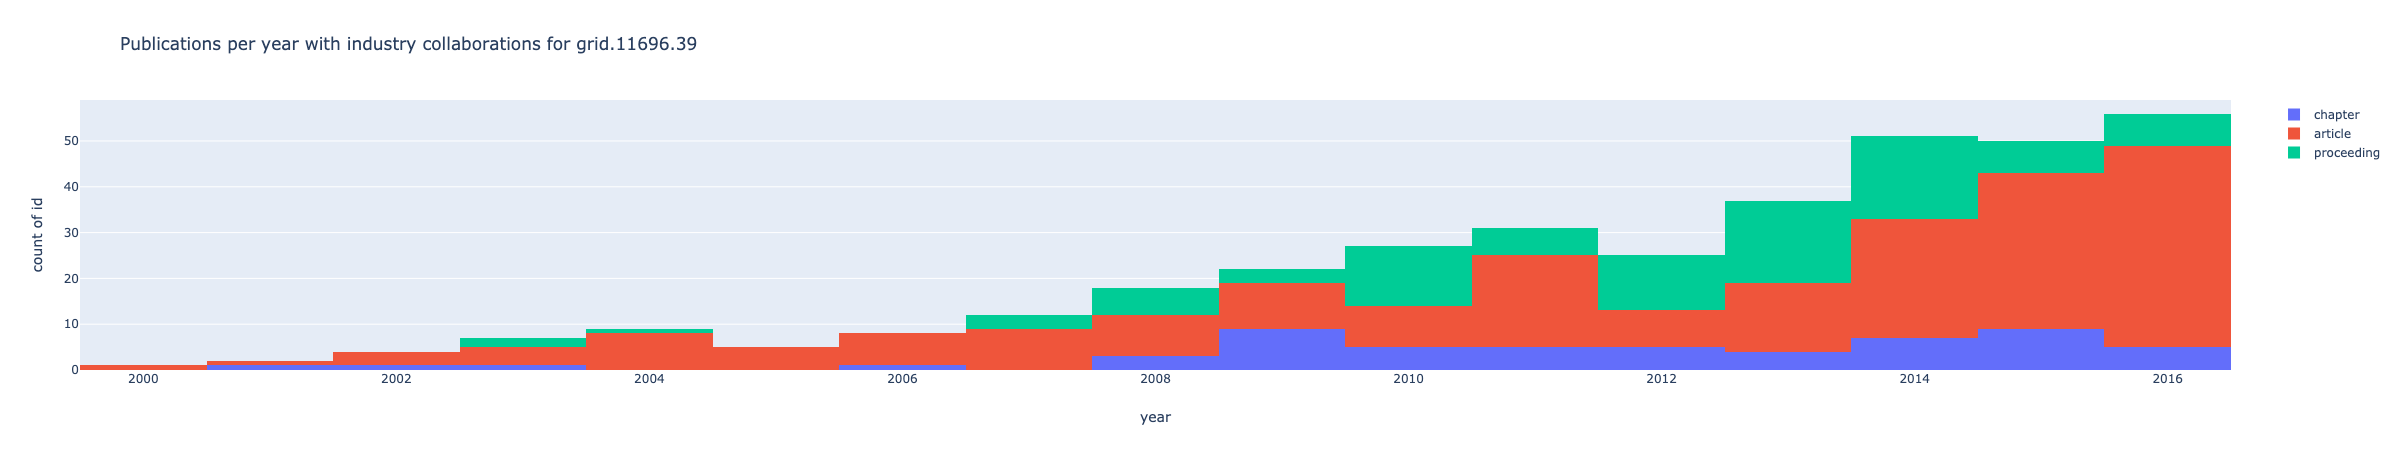

In [6]:
px.histogram(pubs, x="year", y="id", color="type",
                title=f"Publications per year with industry collaborations for {GRIDID}")

## Citations from Industry Collaboration

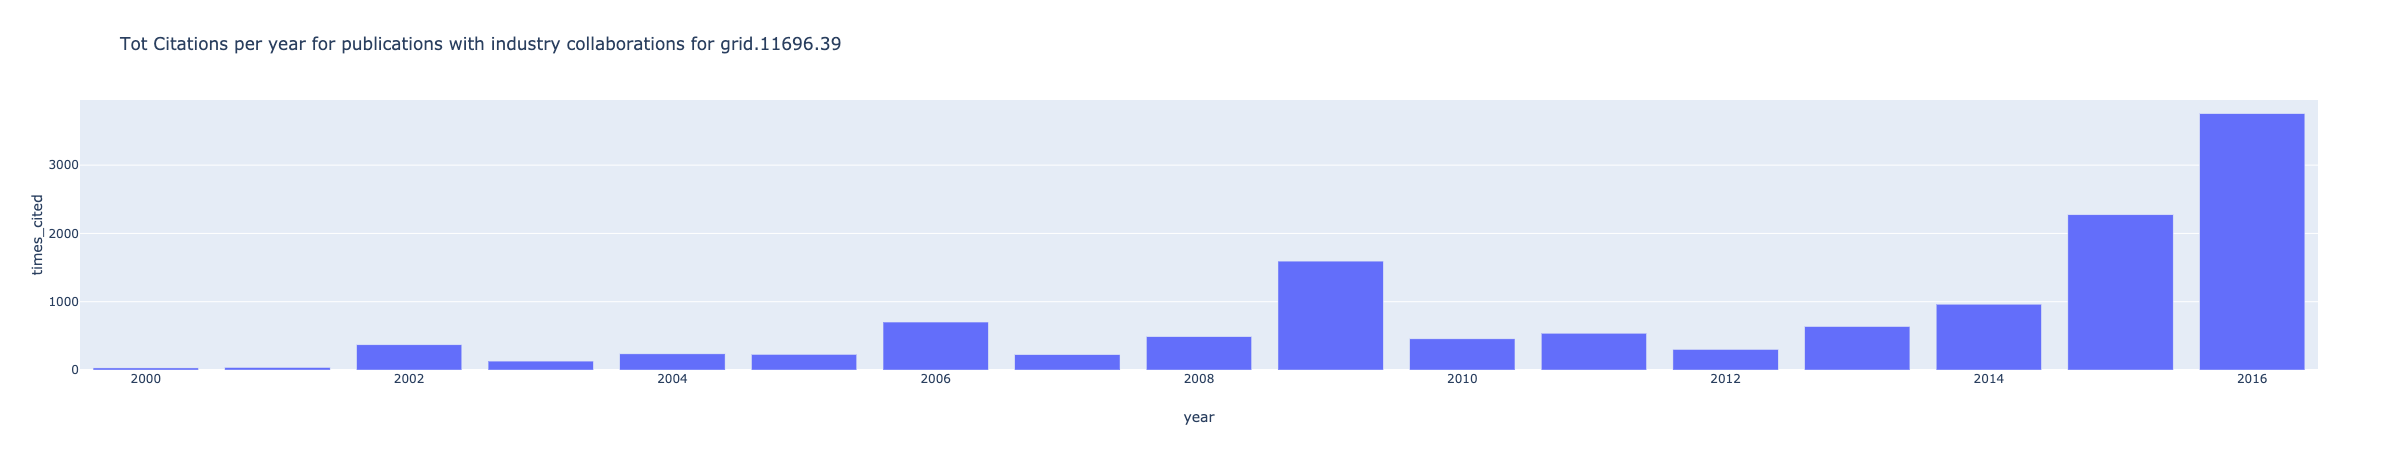

In [7]:
pubs_grouped = pubs.groupby(['year'], as_index=False).sum()
px.bar(pubs_grouped, x="year", y="times_cited",
       title=f"Tot Citations per year for publications with industry collaborations for {GRIDID}")

## Top Industry Collaborators

In order to dig deeper into the industry affiliations we have to process the **nested JSON data** in the 'authors' column. By doing so, we can process authors & affiliations information and identify the ones belonging to the 'industry' set defined above.  

For example, if we extract the authors data for the first publication/row (`pubs.iloc[0]['authors']`), this is what it'd look like: 

```
[{'first_name': 'LUCA DALLA',
  'last_name': 'VALLE',
  'corresponding': '',
  'orcid': '',
  'current_organization_id': 'grid.11696.39',
  'researcher_id': 'ur.013645226073.38',
  'affiliations': [{'id': 'grid.11696.39',
    'name': 'University of Trento',
    'city': 'Trento',
    'city_id': 3165243,
    'country': 'Italy',
    'country_code': 'IT',
    'state': None,
    'state_code': None}]},
 {'first_name': 'ELENA CRISTINA',
  'last_name': 'RADA',
  'corresponding': '',
  'orcid': "['0000-0003-0807-1826']",
  'current_organization_id': 'grid.18147.3b',
  'researcher_id': 'ur.01344320306.26',
  'affiliations': [{'id': 'grid.11696.39',
    'name': 'University of Trento',
    'city': 'Trento',
    'city_id': 3165243,
    'country': 'Italy',
    'country_code': 'IT',
    'state': None,
    'state_code': None}]},
 {'first_name': 'MARCO',
  'last_name': 'RAGAZZI',
  'corresponding': '',
  'orcid': '',
  'current_organization_id': 'grid.11696.39',
  'researcher_id': 'ur.0655652202.53',
  'affiliations': [{'id': 'grid.11696.39',
    'name': 'University of Trento',
    'city': 'Trento',
    'city_id': 3165243,
    'country': 'Italy',
    'country_code': 'IT',
    'state': None,
    'state_code': None}]},
 {'first_name': 'MICHELE',
  'last_name': 'CARAVIELLO',
  'corresponding': '',
  'orcid': '',
  'current_organization_id': 'grid.14587.3f',
  'researcher_id': 'ur.016015622301.36',
  'affiliations': [{'id': 'grid.14587.3f',
    'name': 'Telecom Italia (Italy)',
    'city': 'Rome',
    'city_id': 3169070,
    'country': 'Italy',
    'country_code': 'IT',
    'state': None,
    'state_code': None}]}]
```

NOTE: Instead of iterating through the authors/affiliations data by building a new function, we can just take advantage of the `Dataset` class in the [Dimcli](https://digital-science.github.io/dimensions-api-lab/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html) library. This class abstracts the notion of a Dimensions 'results list' and provides useful methods to quickly process authors and affiliations.

In [8]:
# create a new Dataset instance
pubsnew = Dataset.from_publications_list(pubs)
# extract affiliations as a dataframe
affiliations = pubsnew.as_dataframe_authors_affiliations()
# focus only on affiliations including a grid from the industry set created above
affiliations = affiliations[affiliations['aff_id' ].isin(gridis)]
# preview the data
affiliations.head(5)

,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
3,Rome,3.16907e+06,Italy,IT,grid.14587.3f,Telecom Italia (Italy),,,pub.1087081818,ur.016015622301.36,MICHELE,CARAVIELLO
11,Hamburg,2.9113e+06,Germany,DE,grid.410308.e,Airbus (Germany),,,pub.1059063534,,N,Brandt
12,Milan,3.17344e+06,Italy,IT,grid.424032.3,Orbitale Hochtechnologie Bremen (Italy),,,pub.1059063534,ur.014542047336.90,A,Bursi
19,Milan,3.17344e+06,Italy,IT,grid.424032.3,Orbitale Hochtechnologie Bremen (Italy),,,pub.1059063534,,D,Desiderio
20,Milan,3.17344e+06,Italy,IT,grid.424032.3,Orbitale Hochtechnologie Bremen (Italy),,,pub.1059063534,,E,Piersanti


Let's now count frequency and create a nice chart summing up the top industry collaborators.

TIP Try zooming in on the left-hand side to put into focus the organizations that appear most frequently. 

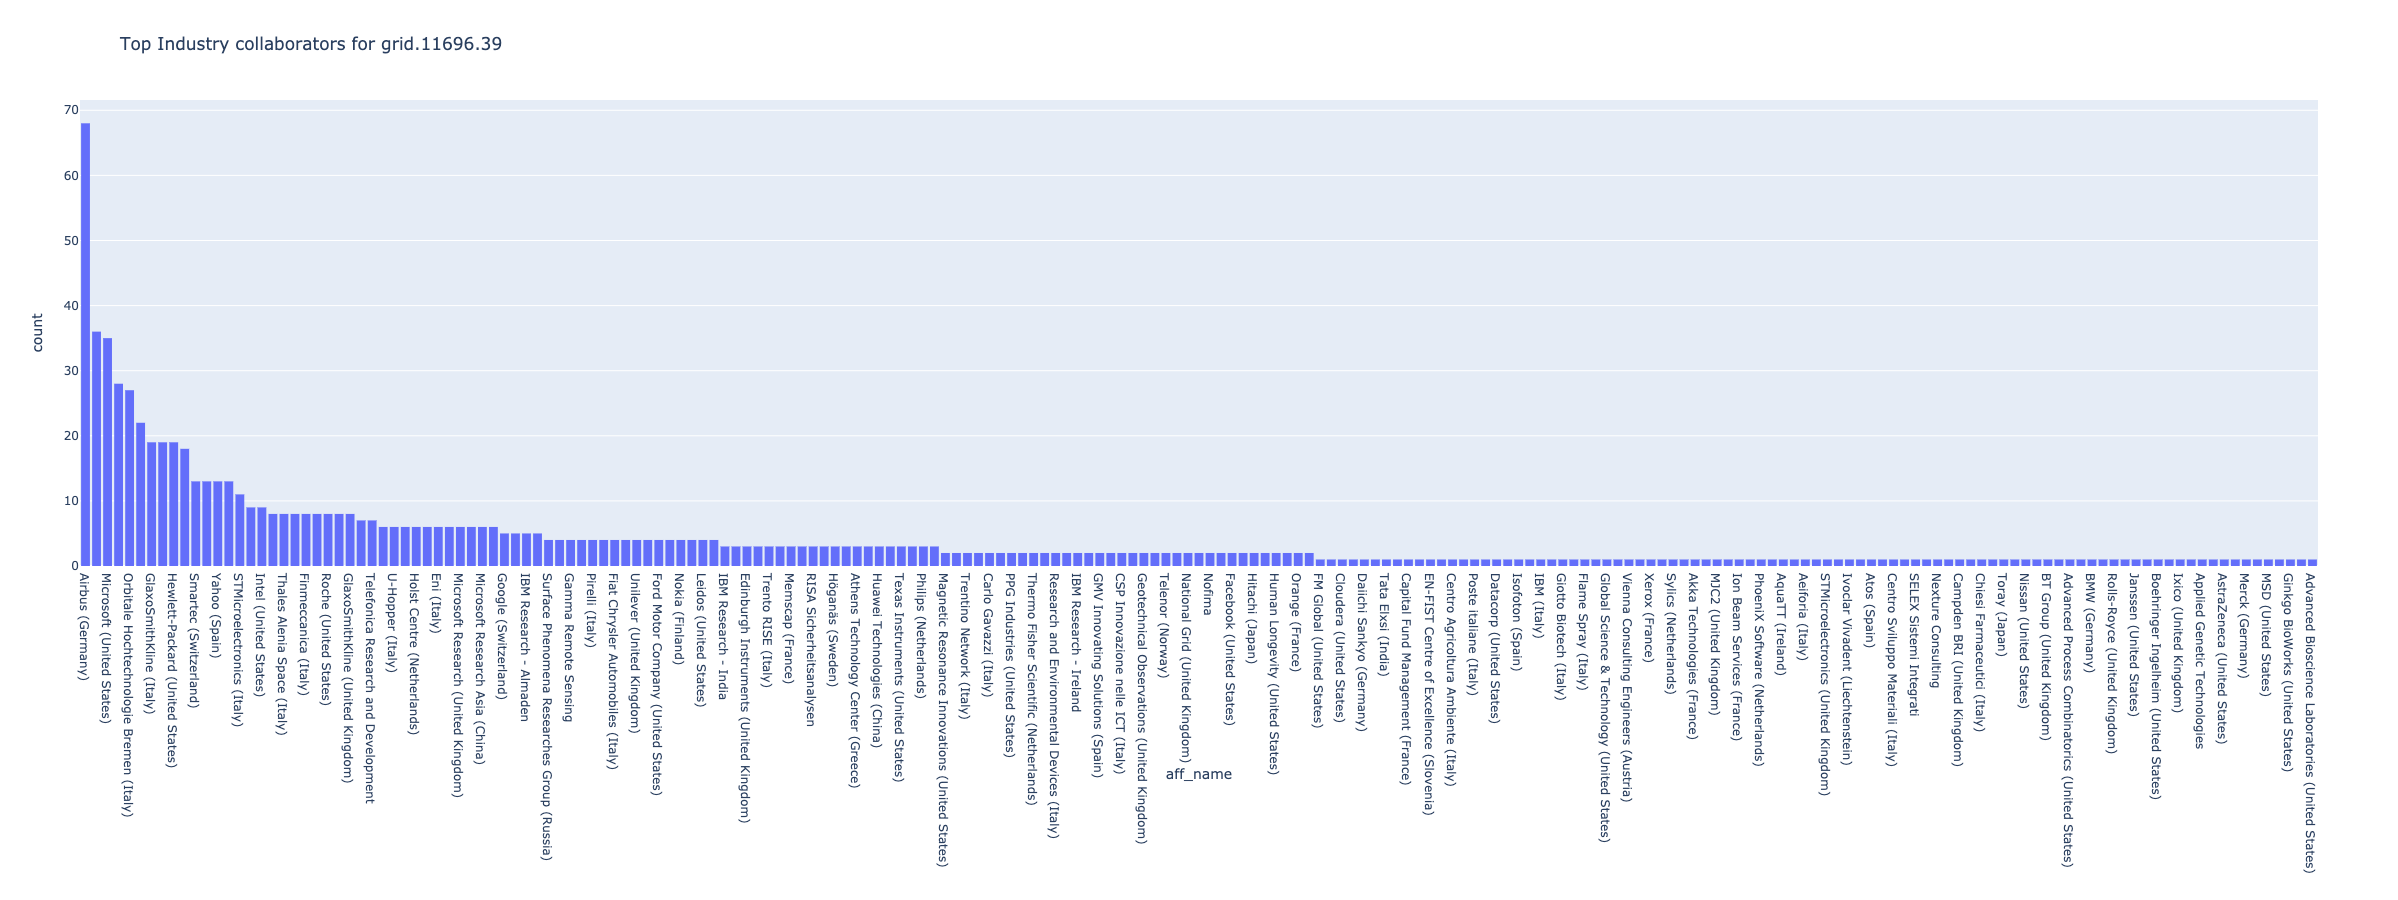

In [9]:
px.histogram(affiliations, x="aff_name", height=900,
             title=f"Top Industry collaborators for {GRIDID}").update_xaxes(categoryorder="total descending")

## Countries of Industry Collaborators

We can use the same dataset to segment the data by country.

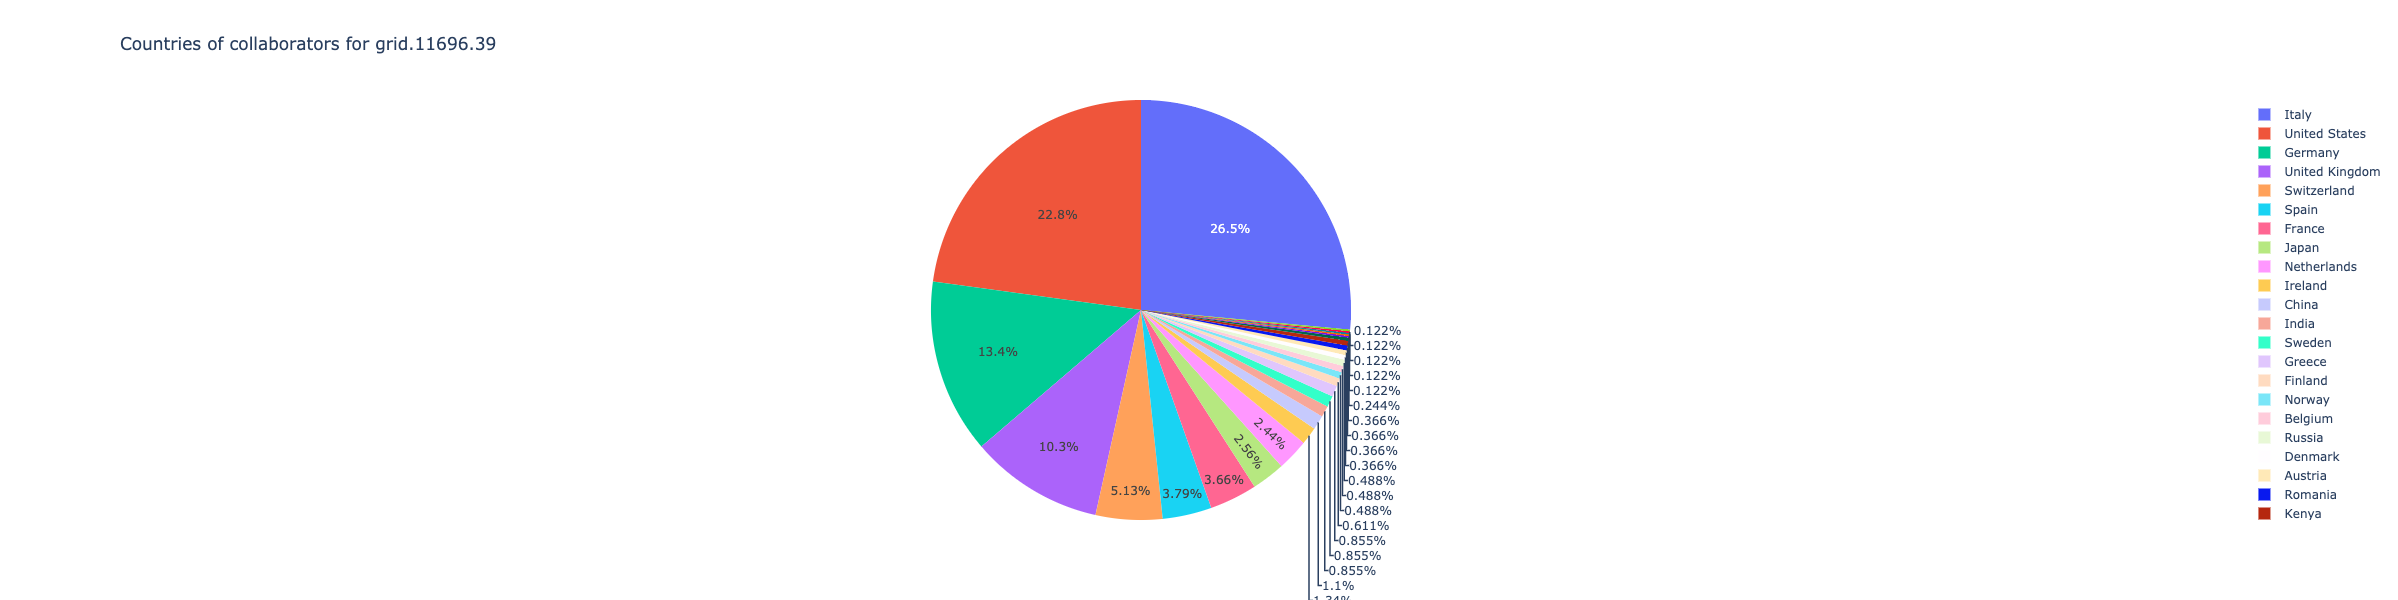

In [10]:
px.pie(affiliations, names="aff_country", height=600, 
      title=f"Countries of collaborators for {GRIDID}")

## Putting Countries and Collaborators together...

**TIP** by clicking on the right panel you can turn on/off specific countries

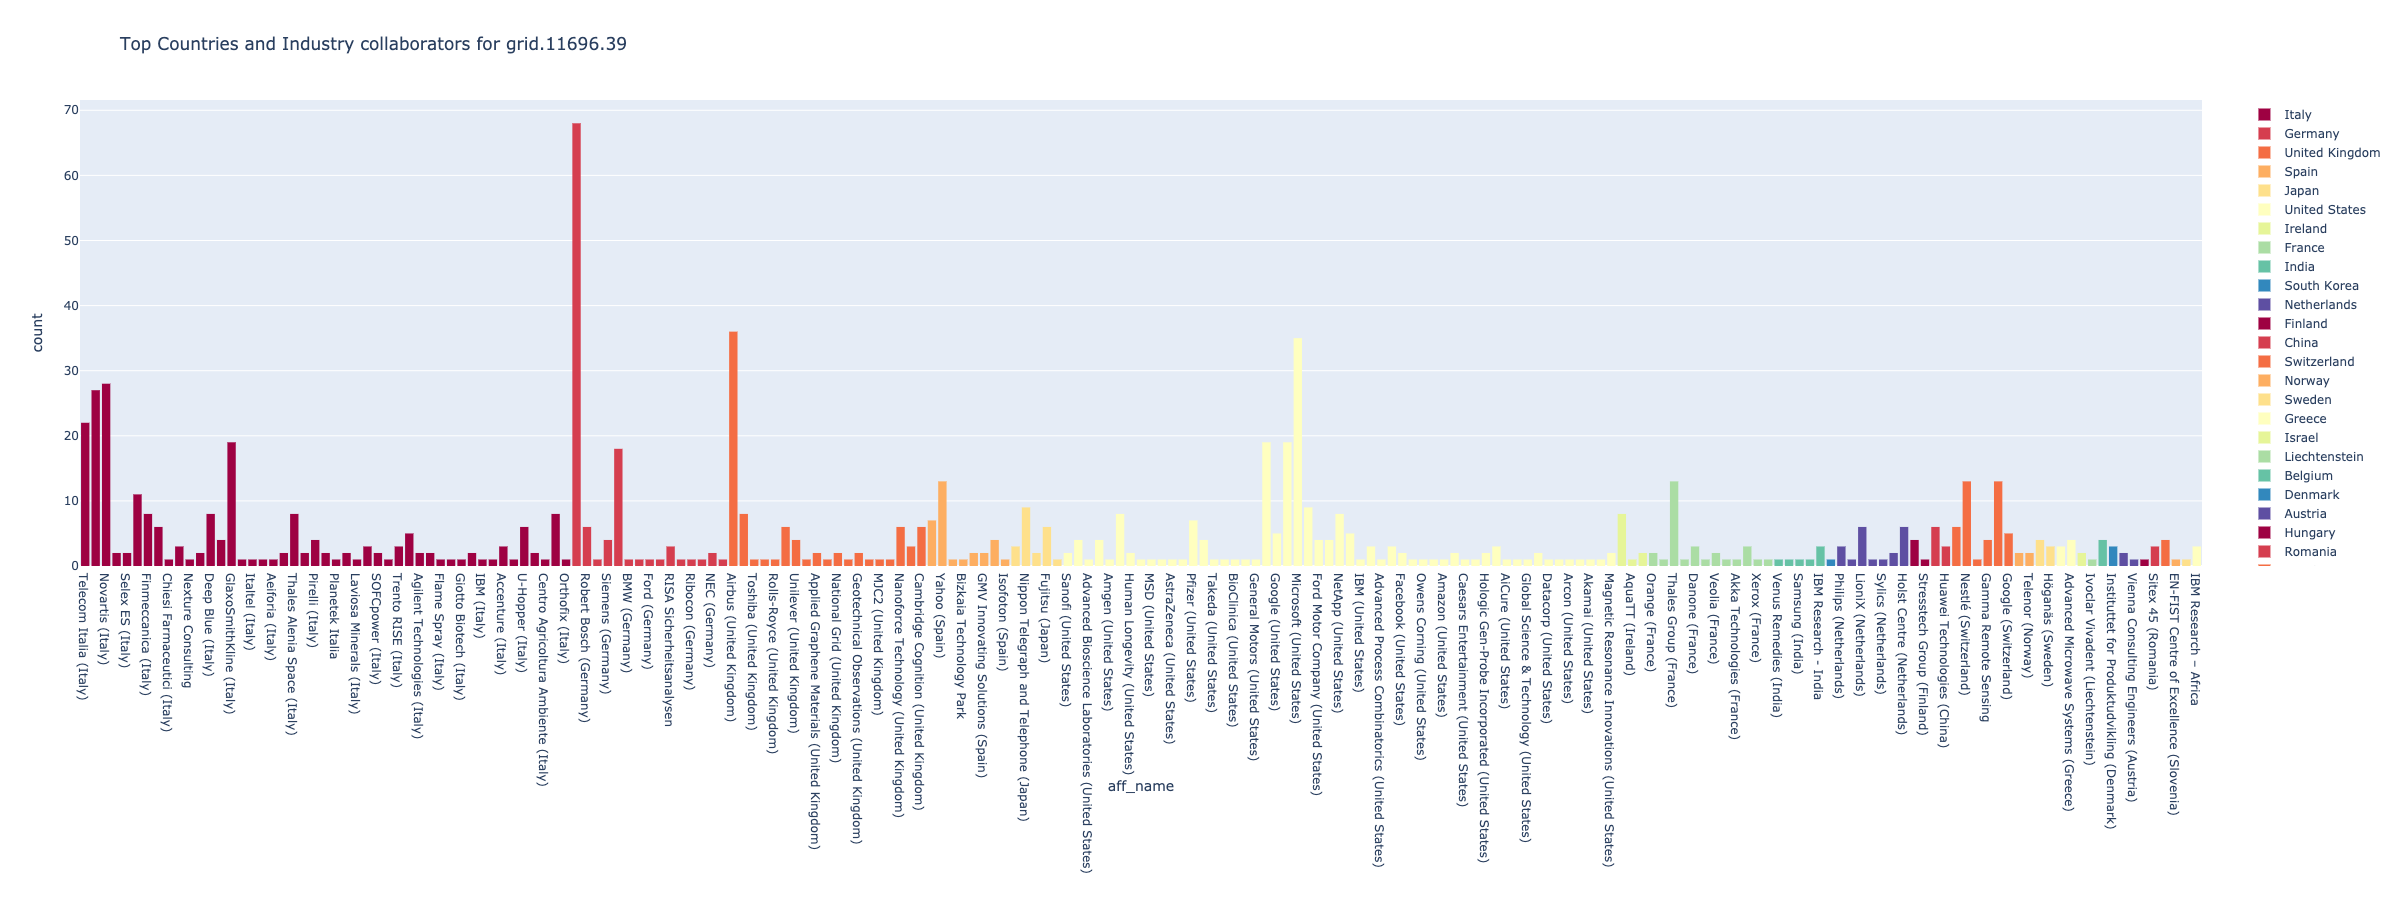

In [11]:
px.histogram(affiliations, x="aff_name", height=900, color="aff_country",
             title=f"Top Countries and Industry collaborators for {GRIDID}",
             color_discrete_sequence=px.colors.diverging.Spectral)